In [1]:
from src.consts import IN_COLAB, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import matplotlib.pyplot as plt
import torch
import numpy as np
import logging
from torchio import RandomAffine, Compose, ZNormalization

import src.dataset.oars_labels_consts as OARS_LABELS
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview
from src.dataset.get_cut_lists import get_cut_lists
from src.dataset.get_full_res_cut import get_full_res_cut
from src.dataset.get_dataset import get_dataset
from src.dataset.get_dataset_info import get_dataset_info
from src.dataset.preview_dataset import preview_dataset
from src.dataset.get_dataset_transform import get_dataset_transform
from src.model_and_training.prepare_model import prepare_model
from src.model_and_training.train_loop import train_loop
from src.model_and_training.show_model_info import show_model_info
from src.helpers.show_cuda_usage import show_cuda_usage
from src.helpers.threshold_calc_helpers import get_rescaled_preds
from src.dataset.split_dataset import split_dataset, copy_split_dataset
from src.helpers.compare_prediction_with_ground_true import compare_prediction_with_ground_true
from src.helpers.get_img_outliers_pixels import get_img_outliers_pixels

from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets

torch.manual_seed(20)
logging.basicConfig(filename='nn_local.log', level=logging.DEBUG)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Low resolution NN

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.transform = Compose([ZNormalization()])
# low_res_dataset.transform = get_dataset_transform()
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
print('low res dataset RAM sizes in GB', low_res_dataset.get_data_size() / 1024**3)

low_res_split_dataset_obj = split_dataset(low_res_dataset, train_size=40, valid_size=5, test_size=5)
get_dataset_info(low_res_dataset, low_res_split_dataset_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(low_res_split_dataset_obj)

CUDA using 16x dataset
filtering labels
filtering labels done
dilatating 1x dataset
parsing dataset to numpy
numpy parsing done
data type: int16 int8
low res dataset RAM sizes in GB 0.02288818359375
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 12.505672454833984, min -0.4069788455963135
label max 1, min 0


Output()

## training low res model

In [12]:
import datetime
from src.model_and_training.load_checkpoint_model_info import load_checkpoint_model_info

TRAIN_LOW_MODEL=True

if TRAIN_LOW_MODEL:
    # preparing model loop params
    low_res_model_info = prepare_model(epochs=500, 
                                       learning_rate=3e-4,
                                       in_channels=4,
                                       dropout_rate=0.2,
                                       train_batch_size=4,
                                       train_dataset=train_low_res_dataset, valid_dataset=valid_low_res_dataset, test_dataset=test_low_res_dataset)
    show_model_info(low_res_model_info)

    # running training loop
    train_loop(low_res_model_info)
    
    # model export
    low_res_model = low_res_model_info['model']
else:
    epoch = 110
    log_date = datetime.datetime(year=2020, month=10, day=26, hour=16, minute=3, second=38).strftime("%Y%m%d-%H%M%S")
    model_name = f'{log_date}_3d_unet'

    loaded_model_info = load_checkpoint_model_info(model_name, epoch, train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset)

    # model export
    low_res_model_info = loaded_model_info
    low_res_model = loaded_model_info['model']

Device running "cuda"
max output channels 64
Model number of params: 298881, trainable 298881
Running training loop
Batch train [1] loss 0.97868, dsc 0.02132
Batch train [2] loss 0.97697, dsc 0.02303
Batch train [3] loss 0.97572, dsc 0.02428
Batch train [4] loss 0.97679, dsc 0.02321
Batch train [5] loss 0.97250, dsc 0.02750
Batch train [6] loss 0.97422, dsc 0.02578
Batch train [7] loss 0.97080, dsc 0.02920
Batch train [8] loss 0.97474, dsc 0.02526
Batch train [9] loss 0.97486, dsc 0.02514
Batch train [10] loss 0.97237, dsc 0.02763
Epoch [1] train done
Batch eval [1] loss 0.97934, dsc 0.02066
Batch eval [2] loss 0.98218, dsc 0.01782
Batch eval [3] loss 0.97965, dsc 0.02035
Batch eval [4] loss 0.98409, dsc 0.01591
Batch eval [5] loss 0.97903, dsc 0.02097
Epoch [1] valid done
Epoch [1] T 4.04s, deltaT 4.04s, loss: train 0.97476, valid 0.98086, dsc: train 0.02524, valid 0.01914
Batch train [1] loss 0.97021, dsc 0.02979
Batch train [2] loss 0.97051, dsc 0.02949
Batch train [3] loss 0.97254,

# Full resolution cutting

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
filtering labels
filtering labels done
parsing dataset to numpy
numpy parsing done
data type: int16 int8
data max 15.305964469909668, min -1.1480365991592407
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## Testing low res network


### getting bounding box cut in full res

In [6]:
full_res_split_dataset_obj = copy_split_dataset(full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(full_res_dataset, full_res_split_dataset_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [7]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model = low_res_model.to('cpu')
#low_res_model.to(low_res_model_info['device'])
low_res_model.eval()

low_res_model_info['model'] = low_res_model
torch.cuda.empty_cache()
print('moved model to cpu')

show_cuda_usage()

moved model to cpu
CUDA Memory Usage
GPU:        GeForce RTX 2070
Allocated:  0.0 GB
Cached:     0.0 GB
Max memory: 0.4 GB
Max Cached: 0.5 GB


In [8]:
dataset_index = 32

raw_low_data =  low_res_dataset.data_list[dataset_index]
raw_low_label = low_res_dataset.label_list[dataset_index]
raw_full_data = full_res_dataset.data_list[dataset_index]
raw_full_label = full_res_dataset.label_list[dataset_index]

tmp = get_full_res_cut(low_res_model=low_res_model, 
                       raw_low_res_data_img=raw_low_data,
                       raw_low_res_label_img=raw_low_label,
                       raw_full_res_data_img=raw_full_data, 
                       raw_full_res_label_img=raw_full_label,
                       low_res_mask_threshold=0.5,
                       desire_bounding_box_size=DESIRE_BOUNDING_BOX_SIZE, 
                       show_debug=True)

debug removing 35 outlier pixels from 1711
debug box delta [15 48  8]
debug, Does cut and original label contain the same amount of pixels? True 1648187 1648187
debug bounding box sizes (57, 144, 160) (72, 192, 168)
debug bounding boxes (58, 114, 176, 319, 176, 335) (51, 122, 152, 343, 172, 339)


Output()

Output()

## Running cut algorithm, creating cut dataset

In [9]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

getting cut index 0
debug removing 9 outlier pixels from 1333
debug box delta [20 48 24]
debug, Does cut and original label contain the same amount of pixels? True 1223526 1223526
getting cut index 1
debug removing 0 outlier pixels from 1332
debug box delta [24 16 -8]
debug, Does cut and original label contain the same amount of pixels? True 1326052 1326052
getting cut index 2
debug removing 0 outlier pixels from 1784
debug box delta [ 19   0 -24]
debug, Does cut and original label contain the same amount of pixels? True 1890464 1890464
getting cut index 3
debug removing 0 outlier pixels from 1489
debug box delta [17 16  8]
debug, Does cut and original label contain the same amount of pixels? True 1560217 1560217
getting cut index 4
debug removing 8 outlier pixels from 1440
debug box delta [20 48 -8]
debug, Does cut and original label contain the same amount of pixels? True 1451227 1451227
getting cut index 5
debug removing 0 outlier pixels from 1325
debug box delta [22 32  8]
debug, D

(72, 192, 168) (72, 192, 168)


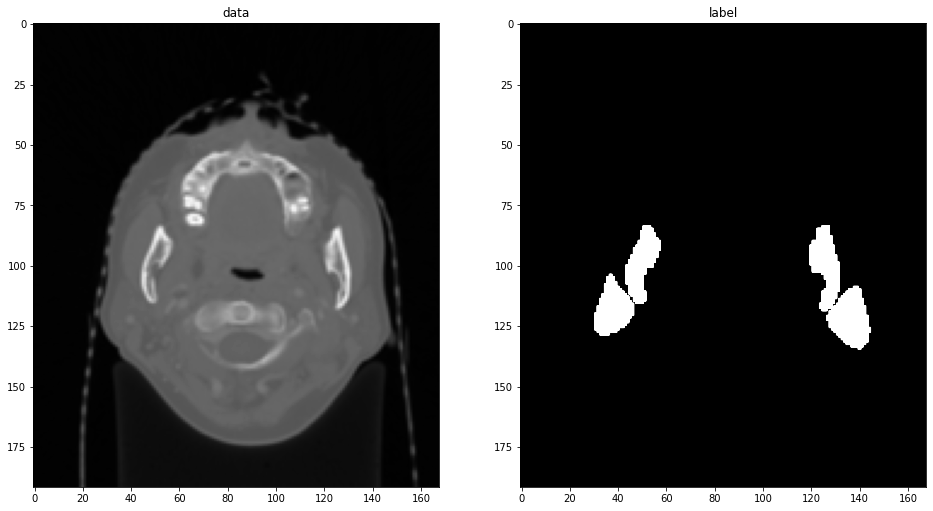

In [10]:
cut_full_res_dataset.set_output_label(None)
debug_data, debug_label = cut_full_res_dataset[48]
debug_data = debug_data[0] # channel dimension
slice_index = 30
print(debug_data.shape, debug_label.shape)


plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1).set_title('data')
plt.imshow(debug_data[slice_index], cmap="gray")

plt.subplot(1, 2, 2).set_title('label')
plt.imshow(debug_label[slice_index], cmap="gray", vmin=0, vmax=1)

plt.show()

### reviewing full res and cut dataset

In [11]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset[0][0].shape, full_res_dataset[1][0].shape)
print('cut full res shape', cut_full_res_dataset[0][0].shape, cut_full_res_dataset[1][0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, max_slices=72)

data type: int16 int8

full res shape (1, 160, 512, 512) (1, 160, 512, 512)
cut full res shape (1, 72, 192, 168) (1, 72, 192, 168)

dataset RAM sizes in GB 5.859375 0.32444000244140625
single item RAM in GB 0.0390625 0.078125

data max 3071, min -1024
label max 22, min 0


Output()

# Full resolution cut model

## Preparing cut dataset

In [ ]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_split_dataset_obj = copy_split_dataset(cut_full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(cut_full_res_dataset, cut_split_dataset_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(cut_split_dataset_obj)

## Training Cut Model

In [ ]:
cut_model_info = prepare_model(epochs=50,
                               learning_rate=5e-4,
                               in_channels=8,
                               dropout_rate=0.2,
                               train_batch_size=2,
                               train_dataset=cut_train_dataset, valid_dataset=cut_valid_dataset, test_dataset=cut_test_dataset)
show_model_info(cut_model_info)

train_loop(cut_train_loop_params)

In [ ]:
show_cuda_usage()

160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

## Cut Model evaluation

In [ ]:
max_slices = cut_train_dataset[0][1].shape[0]

display(Markdown("### Train Eval"))
show_model_dataset_pred_preview(cut_model_info, cut_train_dataset, max_slices=max_slices, default_slice=49)

# display(Markdown("### Valid Eval"))
# show_model_dataset_pred_preview(cut_model_info, cut_valid_dataset, max_slices=max_slices, default_slice=53)

# display(Markdown("### Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

### Showing label prediction comparision

In [ ]:
preds, rescaled_preds = get_rescaled_preds(cut_model_info["model"], cut_full_res_dataset, cut_model_info["device"])

In [ ]:
rnd_train_idx = low_res_split_dataset_obj['train_dataset'].indices[1]
rnd_valid_idx = low_res_split_dataset_obj['valid_dataset'].indices[1]

print(f'Train index {rnd_train_idx}')
compare_prediction_with_ground_true(cut_full_res_dataset, rescaled_preds, pred_threshold=0.5, dataset_index=rnd_train_idx, default_slice=44)
print(f'Valid index {rnd_valid_idx}')
compare_prediction_with_ground_true(cut_full_res_dataset, rescaled_preds, pred_threshold=0.5, dataset_index=rnd_valid_idx, default_slice=41)